### Comparing the Color of Quasars

Jenny Kim, Phil Marshall

[This file](https://github.com/KIPAC/StatisticalMethods/blob/master/examples/SDSScatalog/data/qso10000.csv) contains SDSS quasar magnitudes and redshifts. With the lenspop library, we could compute the synthetic magnitudes in g, r, i, and z filter of the quasar samples in the file. In this notebook, we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $g-r$ magnitude, 4) $r-i$ magnitude, and 5) $i-z$ magnitude between the known SDSS values and the colored magnitudes for each quasar sample.

### Requirements

SDSS data(can be downloaded [here](https://github.com/KIPAC/StatisticalMethods/blob/master/examples/SDSScatalog/data/qso10000.csv)), packages that help reading and writing the data, [color_demo](https://github.com/jennykim1016/OM10/blob/master/notebooks/color_demo.py) to synthetically color the quasars.

In [1]:
import warnings
warnings.filterwarnings('ignore')
# to interactively display the diagrams
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import color_demo
import pandas as pd
import corner
from astropy.table import Table
import numpy as np
from om10 import plotting
import om10
sns.set()
pd.set_option('display.max_columns', None)

In [3]:
#%%capture
db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_mock.fits')
# how to select the quasars?
db.select_random(Nlens=200,maglim=23.6)
db.paint(synthetic=True, target='source')
# save it to different .fits file to save time
# This computation takes less than a second to finish!
#db.write_table('qso_sample_colored.fits')

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 200 lenses


First, let's read in the catalog through pd(panda) and remove any outliers. The key values for the [qso10000](../../StatisticalMethods/examples/SDSScatalog/data/qso10000.csv") files are the followings: objid,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,mag_g,mag_r,mag_i,mag_z,spec_z,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_g1,diff_i,diff_z.

In [4]:
# Read the data
pd.set_option('display.max_columns', None)
qsos = pd.read_csv("../../StatisticalMethods/examples/SDSScatalog/data/qso10000.csv",index_col=0)
# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10) & (qsos["mag_i"]<23.6)]
# Change to Numpy Array because it is easier to manipulate
qso = qsos.as_matrix()

We initialize the array for redshift, $i$-magnitude, $G-R$ magnitude, $R-I$ magnitude, and $I-Z$ magnitude. Then, we select 50 random numbers from 0 to length of qso array, painting them with the color_demo file which extends lenspop library to compute the synthetic magnitude.

Then, we need to weight the mocked lenses with respect to the parent population. The parent population would be gaussian distributed, and the mean would be given by $np.mean(z)$ and the standard deviation would be given by $np.std(z)$.

The weight could be calculated by using this formula:

$$\frac { P(redshift) }{ Q(redshift) } $$

where P(redshift) is a y-value of redshift in the parent normal distribution and Q(redshift) is a y-value of redshift in the mock, colored lenses. `gaussian_reweight` method in OM10 does the calculation.

In [5]:
%%capture
matplotlib.rc('text', usetex=False)
# need the real redshift values from the gaussian parent population to calculate the weights
zReal = qsos["spec_z"].as_matrix()
zReal = zReal[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]

db.gaussian_reweight(np.mean(zReal), np.std(zReal))

Draw the cornerplot with the arguments in axis_labels and save it first so that we could overlap it with the second cornerplot. Two cornerplot seems a lot, but corner.corner automatically displays the cornerplot in jupyter. In order to suppress this particular cornerplot, we used `%%capture`.

In addition, om10 uses usetex=True, which sometimes generates error when using matplotlib. To be safe, let's disable usetex by doing the command `matplotlib.rc('text', usetex=False)`.

In [10]:
%%capture
#om10 uses usetex=True, which sometimes generates error when using matplotlib. To be safe, let's disable usetex.
matplotlib.rc('text', usetex=False)
# GR Color index
gr = db.sample['g_SDSS'] - db.sample['r_SDSS']
ri = db.sample['r_SDSS'] - db.sample['i_SDSS']
iz = db.sample['i_SDSS'] - db.sample['z_SDSS']
data = Table({'i_SDSS': db.sample['i_SDSS'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
fig = corner.corner(features, labels=labels, color='blue', smooth=1.0, hist_kwargs=dict(normed=True))

Get the original SDSS data of $i$-magnitudes, redshifts, $G-R$ magnitudes, $R-I$ magnitudes, and $I-Z$ magnitudes as an array. Remove outliers based on the redshift and the $i$-magnitude. 

In [11]:
i = qsos["mag_i"].as_matrix()
gr = qsos["g_r_color"].as_matrix()
ri = qsos["r_i_color"].as_matrix()
iz = qsos["i_z_color"].as_matrix()

i = i[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]
gr = gr[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]
ri = ri[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]
iz = iz[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]

z = zReal

Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap.

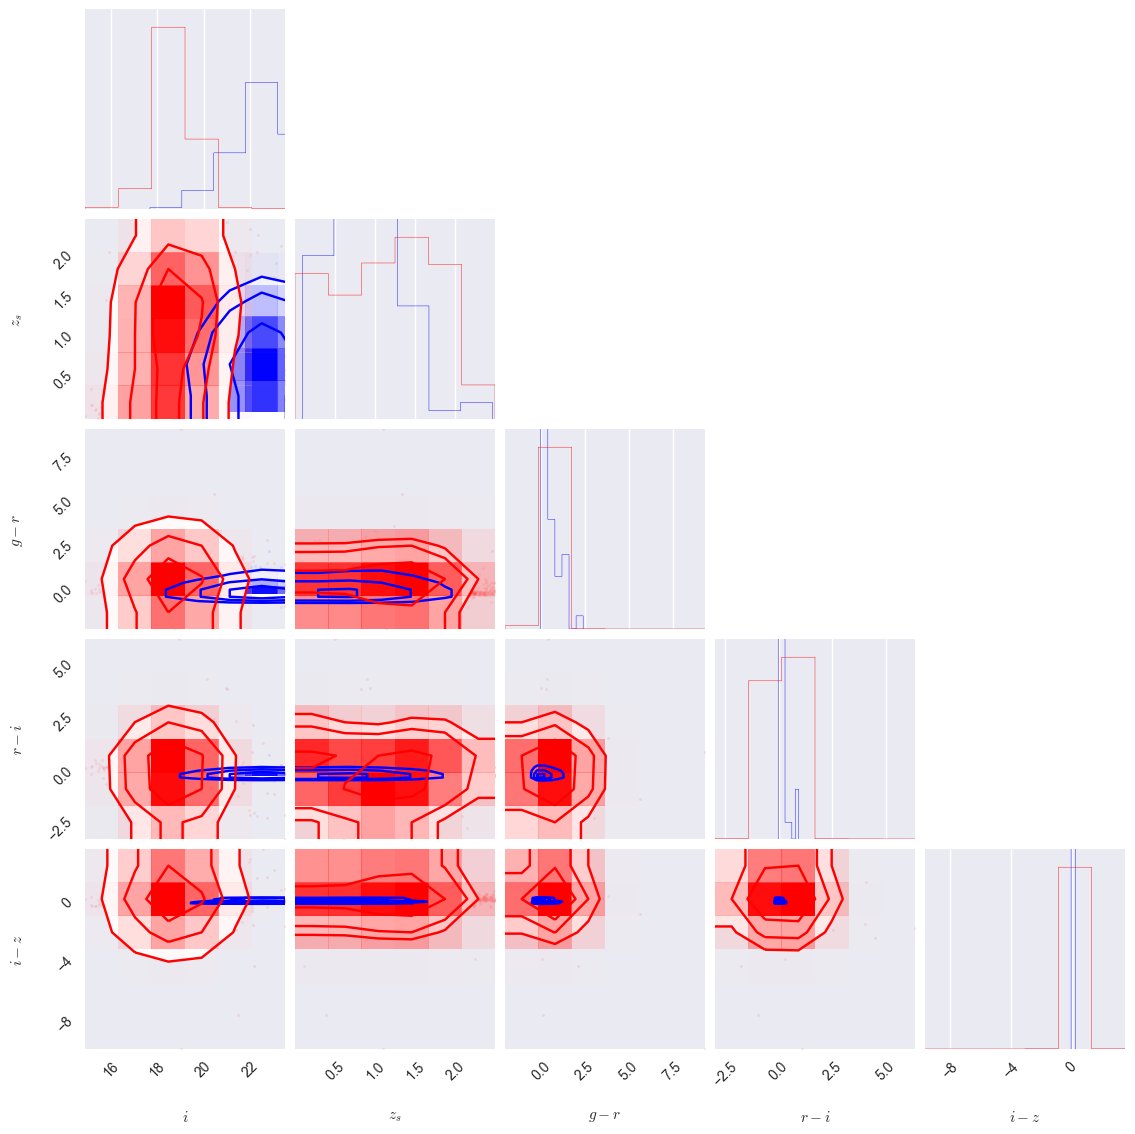

In [12]:
matplotlib.rc('text', usetex=False)
data = Table({'MAGI_Q': i, 'ZSRC': z, 'GR': gr, 'RI': ri, 'IZ': iz}, names=['MAGI_Q', 'ZSRC', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('MAGI_Q','ZSRC', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, hist_kwargs=dict(normed=True), fig=fig)

### Discussion

Red(the real data) seems to have wider distribution than the blue(synthetically colored data). The cornerplot suggests that the red(the real data) and the blue(synthetically colored data) mostly have similar average values. Histogram matched pretty well with each other.